In [1]:
import sys
print(f'Working with Python {sys.version}')

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import rdkit.Chem.Descriptors as Descriptors
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import pymzml
import numpy as np
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')



# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
import fiora.IO.mspReader as mspReader
import fiora.IO.mgfReader as mgfReader
import fiora.visualization.spectrum_visualizer as sv


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


In [2]:
path: str = f"{home}/data/metabolites/MSnLib/" 

dfs = []
for filename in os.listdir(path):
    if filename.endswith("MS2.mgf"):
        filepath = path + filename
        print(f"Reading {filename}")
        df = pd.DataFrame(mgfReader.read(path + filename))
        df["file"] = filename
        df["lib"] = "MSnLib"
        df["origin"] = filename.split("_")[1]
        df["Collision energy"] = df["Collision energy"].astype(float)
        dfs.append(df)

df = pd.concat(dfs)
df.reset_index(inplace=True)

Reading 20240411_mcebio_library_pos_all_lib_MS2.mgf
Reading 20231031_nihnp_library_neg_all_lib_MS2.mgf
Reading 20231130_otavapep_library_pos_all_lib_MS2.mgf
Reading 20231130_mcescaf_library_pos_all_lib_MS2.mgf
Reading 20231031_nihnp_library_pos_all_lib_MS2.mgf
Reading 20231130_otavapep_library_neg_all_lib_MS2.mgf
Reading 20231130_mcescaf_library_neg_all_lib_MS2.mgf
Reading 20240411_mcebio_library_neg_all_lib_MS2.mgf


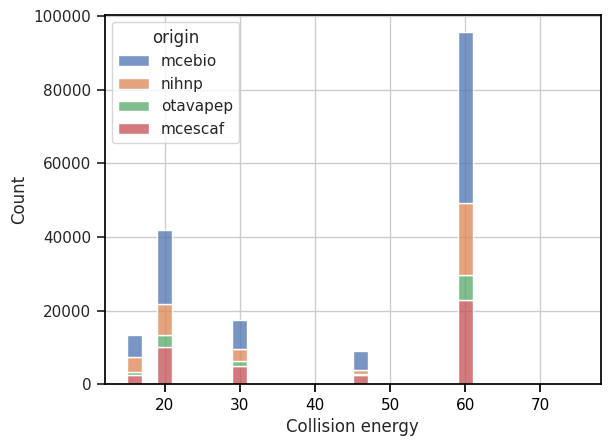

In [3]:
from fiora.visualization.define_colors import *
set_light_theme()
sns.histplot(data=df, x="Collision energy", hue="origin", multiple="stack", binwidth=2)
plt.show()


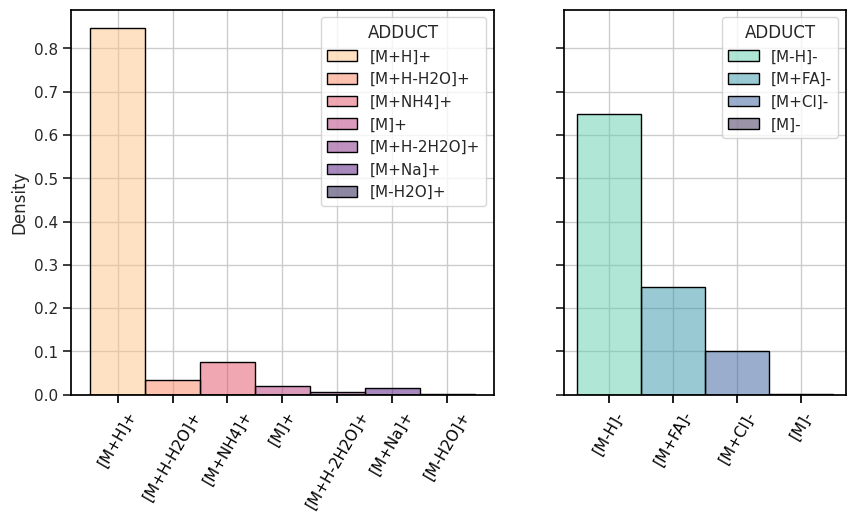

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1.5, 1]}, sharey=True)
#plt.subplots_adjust(wspace=0.1, hspace=0.05)

sns.histplot(ax=axs[0], data=df[df["IONMODE"] == "Positive"], x="ADDUCT", palette=magma(7), hue="ADDUCT", edgecolor="black", stat="density")
axs[0].tick_params(axis='x', rotation=60)
axs[0].set_xlabel("")
sns.histplot(ax=axs[1], data=df[df["IONMODE"] == "Negative"], x="ADDUCT", palette=sns.color_palette("mako_r", 4), hue="ADDUCT", edgecolor="black", stat="density")
axs[1].set_xlabel("")
axs[1].tick_params(axis='x', rotation=60)
plt.show()

In [5]:
from fiora.MOL.Metabolite import Metabolite
from fiora.MOL.constants import PPM
PPM_NUM: int = 10
TOLERANCE = PPM_NUM * PPM

In [6]:
df["PPM_num"] = PPM_NUM
df["ppm_peak_tolerance"] = TOLERANCE
df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())
df["Metabolite"].apply(lambda x: x.compute_graph_attributes())
df["Metabolite"].apply(lambda x: x.fragment_MOL())
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=TOLERANCE), axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
177385    None
177386    None
177387    None
177388    None
177389    None
Length: 177390, dtype: object

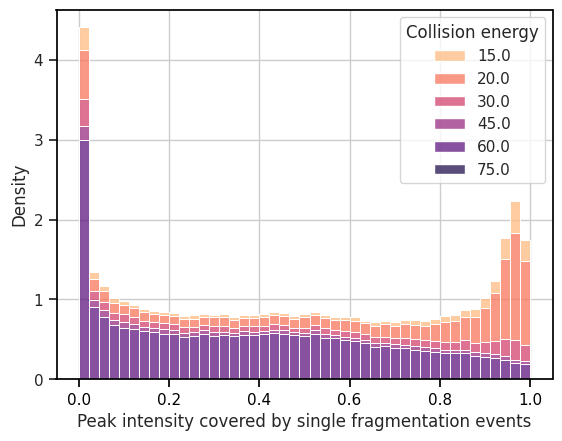

In [7]:
df["coverage"] = df["Metabolite"].apply(lambda x: x.match_stats["coverage"])
sns.histplot(df, x="coverage", hue="Collision energy", palette=magma(6), multiple="stack", stat="density")
plt.xlabel("Peak intensity covered by single fragmentation events")
plt.show()

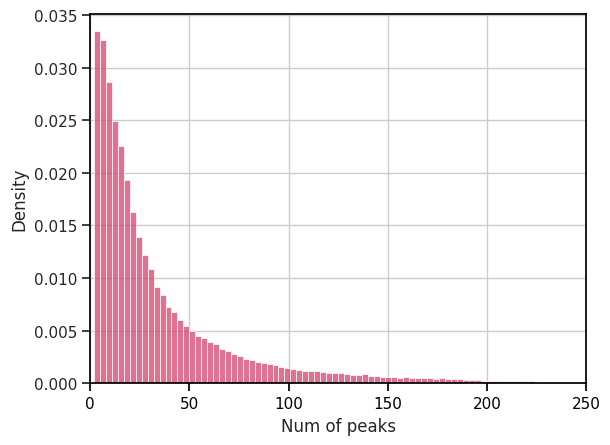

In [8]:
df["Num peaks"] = df["Num peaks"].astype(int)
sns.histplot(df, x="Num peaks",  color=magma(6)[2], multiple="stack", stat="density", binwidth=3, edgecolor="white", linewidth=0.5)
plt.xlabel("Num of peaks")
plt.xlim(0,250)
plt.show()

In [9]:
print("Assign unique metabolite identifiers.")
print("Unique smiles: " + str(len(df["SMILES"].unique())))

metabolite_id_map = {}
for metabolite in df["Metabolite"]:
    is_new = True
    for id, other in metabolite_id_map.items():
        if metabolite == other:
            metabolite.set_id(id)
            is_new = False
            break
    if is_new:
        new_id = len(metabolite_id_map)
        metabolite.id = new_id
        metabolite_id_map[new_id] = metabolite

df["group_id"] = df["Metabolite"].apply(lambda x: x.get_id())
df["num_per_group"] = df["group_id"].map(df["group_id"].value_counts())

for i, data in df.iterrows():
    data["Metabolite"].set_loss_weight(1.0 / data["num_per_group"])
df["loss_weight"] = df["Metabolite"].apply(lambda x: x.loss_weight)
print(f"Found {len(metabolite_id_map)} unique molecular structures.")

def print_df_stats(df):
    num_spectra = df.shape[0]
    num_ids = len(df["group_id"].unique())
    
    print(f"Dataframe stats: {num_spectra} spectra covering {num_ids} unique structures")

print_df_stats(df)

Assign unique metabolite identifiers.
Unique smiles: 16392
Found 15967 unique molecular structures.
Dataframe stats: 177390 spectra covering 15967 unique structures


### Begin filtering

In [10]:
cast_float = ["PEPMASS", "RTINSECONDS", "Collision energy"]
df[cast_float] = df[cast_float].astype(float)
df["ionization"] = "ESI"
df["instrument"] = "HCD"
df["CE"] = df["Collision energy"]
df["Precursor_type"] = df["ADDUCT"]

In [11]:
# TODO HERE #%%capture
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder

metadata_key_map = {
                "name": "NAME",
                "collision_energy":  "Collision energy", 
                "instrument": "instrument",
                "ionization": "ionization",
                "precursor_mz": "PEPMASS",
                "precursor_mode": "Precursor_type",
                "retention_time": "RTINSECONDS",
                }

filter_spectra = True
CE_upper_limit = 100.0
weight_upper_limit = 1000.0
allowed_precursor_modes = ["[M+H]+", "[M-H]-", "[M]+", "[M]-"] # TODO add "[M]+" and [M]-


node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

if filter_spectra:
    setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
    setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
    rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

if filter_spectra:
    df = df[df['ADDUCT'].isin(allowed_precursor_modes)]
    num_ori = df.shape[0]
    correct_energy = df["Metabolite"].apply(lambda x: x.metadata["collision_energy"] <= CE_upper_limit and x.metadata["collision_energy"] > 1) 
    df = df[correct_energy]
    correct_weight = df["Metabolite"].apply(lambda x: x.metadata["molecular_weight"] <= weight_upper_limit)
    df = df[correct_weight]    
    print(f"Filtering spectra ({num_ori}) down to {df.shape[0]}")
    df = df[df["SPECTYPE"] != "ALL_ENERGIES"]
    #print(df["Precursor_type"].value_counts())


Filtering spectra (137199) down to 136133


In [12]:
df["SPECTYPE"].value_counts(dropna=False)

SPECTYPE
NaN                      64937
SAME_ENERGY              26823
ALL_MSN_TO_PSEUDO_MS2    22013
Name: count, dtype: int64

In [ ]:
df_backup = df.copy(deep=True)

In [13]:
#
# IMPORTANT: FILTER AND CLEAN DATA
#

drop_index = []
for i,d in df.iterrows():
    M = d["Metabolite"]

    min_coverage = 0.5
    if M.match_stats["coverage"] < min_coverage: # Filter if total coverage is too low
        drop_index.append(i)
    
    min_peaks = 2
    if M.match_stats["num_peak_matches_filtered"] < min_peaks:
        drop_index.append(i)

    # Either condition is enough to keep the spectrum
    desired_peaks = 5 
    desired_peak_percentage = 0.5
    extremly_high_coverage = 0.8
    if (M.match_stats["num_peak_matches_filtered"] < desired_peaks) & (M.match_stats["percent_peak_matches_filtered"] < desired_peak_percentage) & (M.match_stats["coverage"] < extremly_high_coverage):
        drop_index.append(i)

    #if M.match_stats["num_non_precursor_matches"] < 1:
    #    drop_index.append(i)
    # max_conflicts_rel = 0.75
    # if M.match_stats["rel_fragment_conflicts"] > max_conflicts_rel: 
    #     drop_index.append(i)
    
    max_precursor = 0.9
    if M.match_stats["precursor_prob"] > max_precursor: # Filter if fragment coverage is too low (intensity wise)
       drop_index.append(i)

In [14]:
print_df_stats(df)
drop_index = np.unique(drop_index)
print(f"Filtering out {len(drop_index)} that have only precursor matches || or || too little (intensity) coverage to make edge prediction possible")
df = df.drop(drop_index)
print_df_stats(df)

Dataframe stats: 113773 spectra covering 14798 unique structures
Filtering out 68725 that have only precursor matches || or || too little (intensity) coverage to make edge prediction possible
Dataframe stats: 45048 spectra covering 10317 unique structures


### Align train/test sets with other datasets

<Axes: xlabel='coverage', ylabel='Count'>

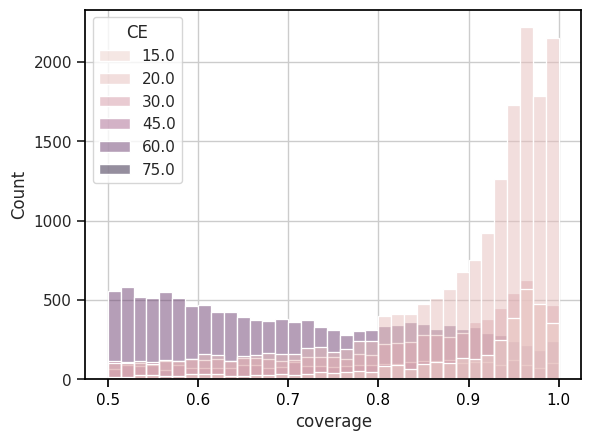

In [15]:
sns.histplot(df, x= "coverage", hue="CE")

In [16]:
from fiora.IO.LibraryLoader import LibraryLoader


train_ids, va_ids, test_ids = [], [], []

L = LibraryLoader()
casmi16_path = f"{home}/data/metabolites/CASMI_2016/casmi16_withCCS.csv"
casmi22_path = f"{home}/data/metabolites/CASMI_2022/casmi22_withCCS.csv"
df_merged = L.load_from_csv(f"{home}/data/metabolites/preprocessed/datasplits_Jan24.csv")
df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
df_cas22 = pd.read_csv(casmi22_path, index_col=[0], low_memory=False)
df_cast = pd.read_csv(f"{home}/data/metabolites/CASMI_2016/casmi16t_withCCS.csv", index_col=[0], low_memory=False)

other_dfs = {
    "train": df_merged[df_merged["dataset"] == "training"].drop_duplicates(subset=["group_id"]),
    "val": df_merged[df_merged["dataset"] == "validation"].drop_duplicates(subset=["group_id"]),
    "test": pd.concat([df_merged[df_merged["dataset"] == "test"].drop_duplicates(subset=["group_id"]), df_cas, df_cast, df_cas22]).drop_duplicates(subset=["SMILES"]),
}

In [17]:
lookup_table = {
    "train": set(),
    "val": set(),
    "test": set()
}
for key, df_x in other_dfs.items():
     df_x["Metabolite"] = df_x["SMILES"].apply(Metabolite)
     
     for i, data in df_x.iterrows():
         lookup_table[key].add((data["Metabolite"].ExactMolWeight, data["Metabolite"].morganFingerCountOnes))
     

In [18]:
train, val, test = [], [], []


for id in df["group_id"].unique():
    metabolite: Metabolite = df[df["group_id"] == id].iloc[0]["Metabolite"]
    fast_identifiers = (metabolite.ExactMolWeight, metabolite.morganFingerCountOnes)
    found_match = False
    
    if fast_identifiers in lookup_table["train"]:
        for i, data in other_dfs["train"].iterrows():
            other_metabolite = data["Metabolite"]
            if metabolite == other_metabolite:
                train.append(id)
                found_match = True
                break
    if not found_match and fast_identifiers in lookup_table["val"]:
        for i, data in other_dfs["val"].iterrows():
            other_metabolite = data["Metabolite"]
            if metabolite == other_metabolite:
                val.append(id)
                break
    if not found_match and fast_identifiers in lookup_table["test"]:
            for i, data in other_dfs["test"].iterrows():
                other_metabolite = data["Metabolite"]
                if metabolite == other_metabolite:
                    test.append(id)
                    break

In [19]:
print(f"Print length: {len(train)=} {len(val)=} {len(test)=}")
print(f"{train[:5]=} {val[-5:]=} {test[5:10]=}")

Print length: len(train)=1089 len(val)=124 len(test)=199
train[:5]=[12, 23, 34, 50, 82] val[-5:]=[5712, 15844, 6044, 15888, 6413] test[5:10]=[733, 748, 830, 947, 987]


In [20]:
from sklearn.model_selection import train_test_split

def train_val_test_split(keys, test_size=0.1, val_size=0.1, rseed=0):
    temp_keys, test_keys = train_test_split(keys, test_size=test_size, random_state=rseed)
    adjusted_val_size = val_size / (1 - test_size)
    train_keys, val_keys = train_test_split(temp_keys, test_size=adjusted_val_size, random_state=rseed)
    
    return train_keys, val_keys, test_keys


In [21]:
group_ids = df["group_id"].astype(int)
keys = np.unique(group_ids)
num_keys = len(keys)
mask = ~np.isin(keys, train + val + test)
unassigned_keys = keys[mask]
num_unassigned = len(unassigned_keys)

desired_split_size = int(num_keys * 0.1)
test_size_remaining = desired_split_size - len(test)
val_size_remaining = desired_split_size - len(val)

test_new_frac = test_size_remaining / num_unassigned
val_new_frac = val_size_remaining / num_unassigned
train_add, val_add, test_add = train_val_test_split(unassigned_keys, test_size=test_new_frac, val_size=val_new_frac)
train = np.concatenate((np.array(train), train_add))
val = np.concatenate((np.array(val), val_add))
test = np.concatenate((np.array(test), test_add))


df["dataset"] = df["group_id"].apply(lambda x: 'training' if x in train else 'validation' if x in val else 'test' if x in test else 'VALUE ERROR')
df["datasplit"] = df["dataset"]

In [24]:
print(f"Unique compounds in each {df.groupby('datasplit')['group_id'].nunique()}")

Unique compounds in each datasplit
test          1031
training      8255
validation    1031
Name: group_id, dtype: int64


### Save datasplits and metadata

In [23]:
raise KeyboardInterrupt("Stop before saving")

KeyboardInterrupt: Stop before saving

In [ ]:
save_df: bool = True
if save_df:
    path: str = f'{home}/data/metabolites/preprocessed/datasplits_msnlib_Aug24_vXXX.csv'
    print(f"Saving datasplits to {path}")
    df.to_csv(path)

Saving datasplits to /home/ynowatzk/data/metabolites/preprocessed/datasplits_msnlib_Aug24_v3_alt.csv


### Additional Statistics

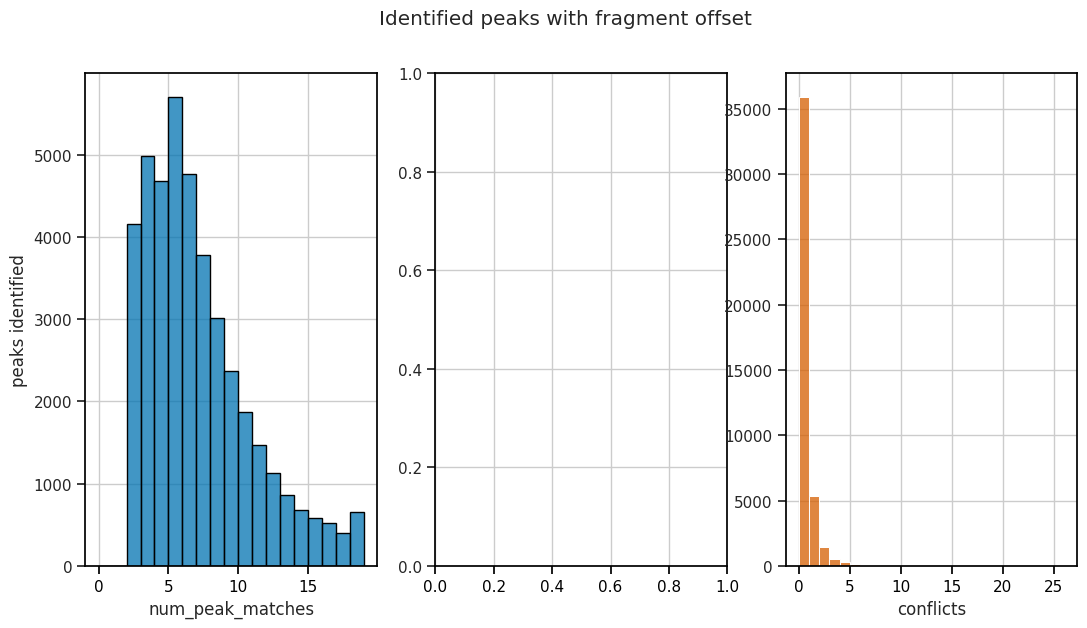

In [ ]:
for stat in df.iloc[0]["Metabolite"].match_stats.keys():
    df[stat] = df["Metabolite"].apply(lambda x: x.match_stats[stat])

fig, axs = plt.subplots(1, 3, figsize=(12.8, 6.4), sharey=False)

fig.suptitle(f"Identified peaks with fragment offset")
#plt.title(f"Identified peaks with fragment offset: {str(off)}")
sns.histplot(ax=axs[0],data=df, x="num_peak_matches", color=color_palette[0], edgecolor="black", bins=range(0,20, 1))
#axs[0].set_ylim(-0.5, 10)
axs[0].set_ylabel("peaks identified")


# sns.boxplot(ax=axs[1],data=df, y="num_unique_peaks_matched", color=color_palette[1])
# axs[1].set_ylim(-0.5, 15)
# axs[1].set_xlabel("unique matches")
# axs[1].set_ylabel("")


sns.histplot(ax=axs[2],data=df, x="num_fragment_conflicts", color=color_palette[3], binwidth=1)
#axs[2].set_ylim(-0.5, 1000)
axs[2].set_xlabel("conflicts")
axs[2].set_ylabel("")

plt.show()

/tmp/ipykernel_851052/1632106418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RETENTIONTIME"] = df["RETENTIONTIME"].astype(float)


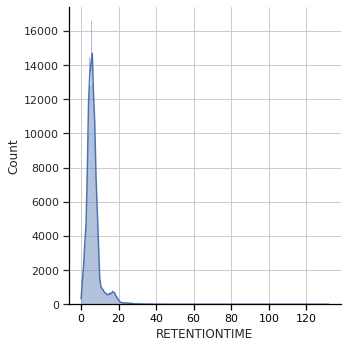

In [ ]:
df["RETENTIONTIME"] = df["RETENTIONTIME"].astype(float)
sns.displot(df, x="RETENTIONTIME", kde=True, binwidth=0.5)
plt.show()

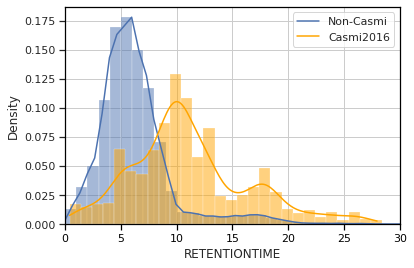

In [ ]:

sns.histplot(df[~df["in_casmi2016"]], x="RETENTIONTIME", kde=True, binwidth=1, stat="density", multiple="stack")
sns.histplot(df[df["in_casmi2016"]], x="RETENTIONTIME", kde=True, binwidth=1, stat="density", multiple="stack", color="orange")
plt.legend(labels=["Non-Casmi", "Casmi2016"])
plt.xlim([0,30])
plt.show()

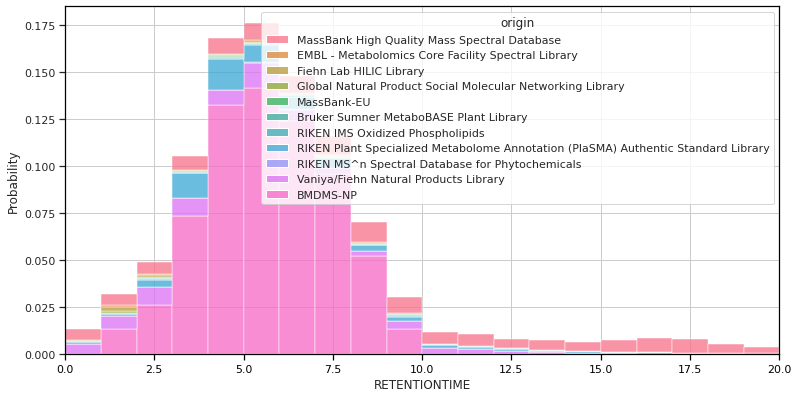

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

sns.histplot(ax=ax, data=df, x="RETENTIONTIME", hue='origin', multiple="stack", binwidth=1, stat="probability")
plt.xlim([0, 20])
plt.show()

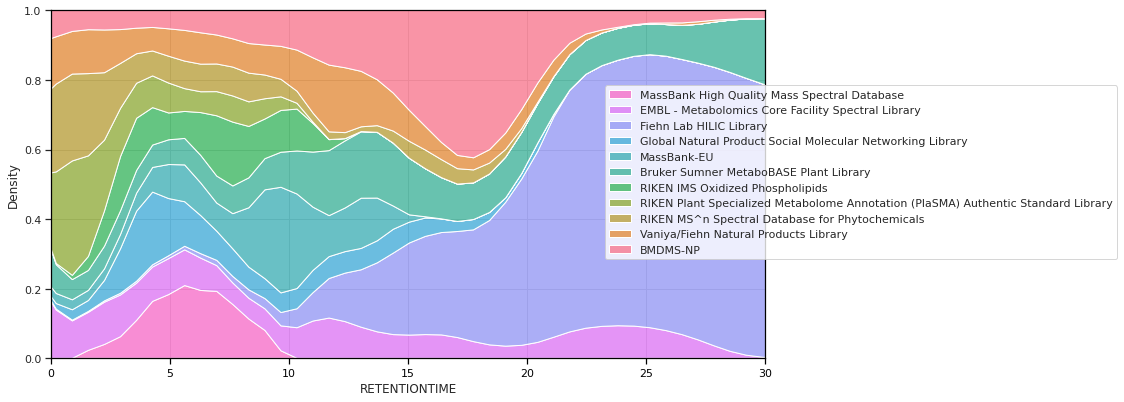

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

sns.kdeplot(ax=ax, data=df, x="RETENTIONTIME", hue='origin', multiple="fill", common_norm=False)
ax.legend(bbox_to_anchor=(1.5, 0.8), labels=df["origin"].unique())
plt.xlim([0, 30])
plt.show()
    
    

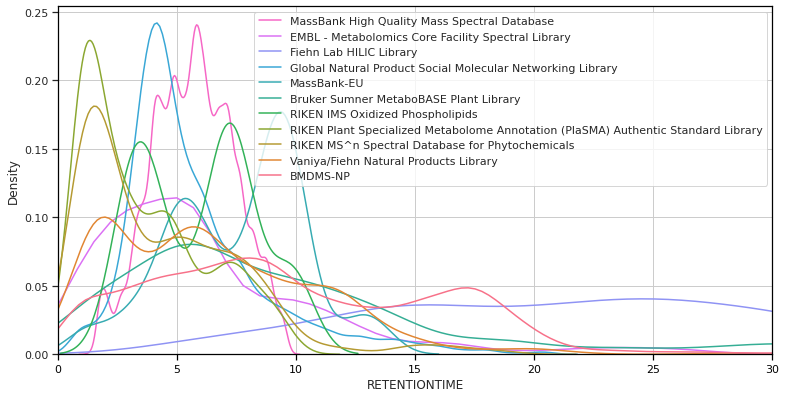

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

sns.kdeplot(ax=ax, data=df, x="RETENTIONTIME", hue='origin', multiple="layer", common_norm=False)
plt.legend(labels=df["origin"].unique())
plt.xlim([0, 30])
plt.show()

In [ ]:
df["origin"].value_counts()

BMDMS-NP                                                                             112495
Vaniya/Fiehn Natural Products Library                                                 29669
MassBank High Quality Mass Spectral Database                                          28151
RIKEN Plant Specialized Metabolome Annotation (PlaSMA) Authentic Standard Library     11587
RIKEN MS^n Spectral Database for Phytochemicals                                        6695
Bruker Sumner MetaboBASE Plant Library                                                 1532
Fiehn Lab HILIC Library                                                                1019
EMBL - Metabolomics Core Facility Spectral Library                                     1013
Global Natural Product Social Molecular Networking Library                              727
RIKEN IMS Oxidized Phospholipids                                                        386
MassBank-EU                                                                     